In [5]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, CenterCrop
import torch
from PIL import Image
import os
from pathlib import Path
import json

class SingleObjectDataset(Dataset):
    def __init__(self, image_dir, json_path, transform=None):
        self.image_dir = Path(image_dir)
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]
        
        self.json_path = json_path
        with open(self.json_path, 'r') as f:
            self.dataset = json.load(f)
        
        # Filter the JSON data for only the images present in the image_dir
        self.image_id_to_info = {
            img['id']: img for img in self.dataset['images'] if img['file_name'] in self.image_files
        }
        
        # Only keep annotations corresponding to the images in the current directory
        self.image_id_to_annotations = {
            ann['image_id']: ann for ann in self.dataset['annotations'] if ann['image_id'] in self.image_id_to_info
        }
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        
        # Load image
        img_path = self.image_dir / img_file
        image = Image.open(str(img_path))
        
        image_info = next((img for img in self.image_id_to_info.values() if img['file_name'] == img_file), None)
        image_id = image_info['id']
        
        annotation_info = self.image_id_to_annotations.get(image_id, None)
        if annotation_info is None:
            raise ValueError(f"No annotation found for image ID {image_id}.")
        
        # Retrieve bounding box and label
        bbox = annotation_info['bbox']
        label = annotation_info['category_id']
        point_xy = annotation_info['point_xy']
        
        if self.transform:
            image = self.transform(image)
        print(f"Image shape: {image.shape}") 
            
        return image, bbox, label, point_xy


# Create the dataset
train_path = 'singleobject/train/images'
val_path = 'singleobject/val/images'
test_path = 'singleobject/test/images'
json_path = Path('instances_train2019.json')

#transform
resize_64 = Compose([
    Resize(size=(640, 640)),
    ToTensor()
])

train_dataset = SingleObjectDataset(train_path, json_path, resize_64)
val_dataset = SingleObjectDataset(val_path, json_path, resize_64)

# Use DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [3]:
import numpy as np
image, bbox, label, point_xy = train_dataset[66]
print(label)
print(bbox)
print(point_xy)
print(image.size())

Image shape: torch.Size([3, 640, 640])
171
[867.56, 929.3, 771.47, 464.36]
[1253.3, 1161.48]
torch.Size([3, 640, 640])


Image shape: torch.Size([3, 640, 640])


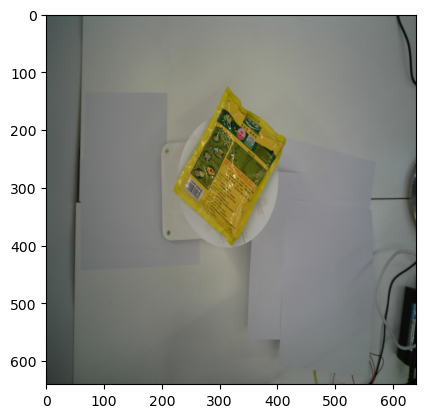

In [28]:
import matplotlib.pyplot as plt

def display_image(axis, image_tensor):
    """Display a tensor as an image

    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """

    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError(
            "The `display_image` function expects a `torch.Tensor` "
            + "use the `ToTensor` transformation to convert the images to tensors."
        )

    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)


# Example usage
_, axis = plt.subplots()
some_random_index = 48000
# Here we use the __getitem__ method as a "magic" method.
# Implementing it for a class, enables square bracket '[]' indexing
image_tensor, _, label, _ = train_dataset[some_random_index]
display_image(axis, image_tensor)

In [17]:
#DOESNT WORK 
import torch.nn.functional as F

def training_loop(
    model, optimizer, loss_fn_cls, loss_fn_bbox, train_loader, val_loader, num_epochs, print_every
):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss = train_epoch(
            model, optimizer, loss_fn_cls, loss_fn_bbox, train_loader, device, print_every
        )
        val_loss = validate(model, loss_fn_cls, loss_fn_bbox, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {train_loss:.3f}, "
            f"Val. loss: {val_loss:.3f}"
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    return model, train_losses, val_losses

def train_epoch(model, optimizer, loss_fn_cls, loss_fn_bbox, train_loader, device, print_every):
    model.train()
    total_loss = 0

    for batch_index, (images, bboxes, labels, point_xy) in enumerate(train_loader):
        images = images.to(device)

        # Convert bboxes and labels to tensors and move to device
        bboxes = [torch.tensor(b).to(device) for b in bboxes] if isinstance(bboxes, list) else bboxes.to(device)
        labels = torch.tensor(labels).to(device) if isinstance(labels, list) else labels.to(device)

        # Convert list of bboxes to a tensor (if they are a list)
        if isinstance(bboxes, list):
            bboxes = torch.stack(bboxes)  # Stack to convert to tensor

        # Check if bboxes are 8-dimensional and select the correct part for bounding boxes
        if bboxes.shape[1] == 8:
            bboxes = bboxes[:, :4]  # Keep only the first 4 coordinates

        # Forward pass
        outputs = model(images)

        # Check the shape of outputs
        print(f"Batch {batch_index}: Model output shape: {outputs.shape}")

        predicted_bboxes = outputs[..., :4]  # Assuming the first 4 are the bounding box coordinates
        predicted_scores = outputs[..., 4:]    # Assuming the remaining are the class scores

        # Ensure shapes of targets
        batch_size = images.shape[0]
        if len(bboxes) < batch_size:
            # Create a tensor for padded bboxes
            padded_bboxes = torch.zeros(batch_size, 4).to(device)  # 4 for bbox coordinates
            padded_bboxes[:len(bboxes)] = bboxes  # Stack and assign existing bboxes
            bboxes = padded_bboxes
        else:
            bboxes = bboxes[:batch_size]  # Ensure that bboxes size matches the batch size

        scores_reshaped = predicted_scores.view(predicted_scores.shape[0], -1, predicted_scores.shape[-1])  # Shape: [8, 615*40, 36]
    
        # Select the highest scoring bounding box for each image
        max_scores, selected_indices = scores_reshaped.max(dim=1)  # Get max scores and their corresponding indices
        
        # Adjust selected_indices to extract valid bounding boxes
        selected_bboxes = predicted_bboxes.view(predicted_bboxes.size(0), -1, 4)  # [batch_size, num_boxes, 4]
        selected_bboxes = selected_bboxes[torch.arange(selected_bboxes.size(0)), selected_indices]  # Use broadcasting here


        # Print shapes for debugging
        print(f"Selected indices: {selected_indices}, Selected indices shape: {selected_indices.shape}")

        # Calculate the loss
        loss_bbox = loss_fn_bbox(selected_bboxes.view(-1, 4), bboxes.view(-1, 4))  # Adjusted view to match
        loss_cls = loss_fn_cls(predicted_scores.view(-1, model.numClasses), labels.view(-1))  # Adjusted view for classification

        # Total loss
        total_loss += loss_bbox + loss_cls

        # Backward pass and optimization
        optimizer.zero_grad()
        (loss_bbox + loss_cls).backward()
        optimizer.step()

        if batch_index % print_every == 0:
            print(f"Batch {batch_index}, Loss: {total_loss.item() / (batch_index + 1):.4f}")

    return total_loss / len(train_loader)

def validate(model, loss_fn_cls, loss_fn_bbox, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (images, bboxes, labels, point_xy) in enumerate(val_loader, 1):
            images = images.to(device)
            bboxes = torch.stack([torch.tensor(b).to(device) for b in bboxes]).to(device) if isinstance(bboxes, list) else bboxes.to(device)
            labels = torch.tensor(labels).to(device) if isinstance(labels, list) else labels.to(device)

            # Forward pass
            outputs = model(images)

            # Separate the outputs into bounding box predictions and class scores
            predicted_boxes = outputs[..., :4]
            predicted_scores = outputs[..., 4:]

            # Ensure bboxes have the same shape as predicted_boxes
            if bboxes.shape[0] != predicted_boxes.shape[0]:
                bboxes = bboxes[:predicted_boxes.shape[0]]  # Adjust if necessary

            # Calculate validation losses
            loss_bbox = loss_fn_bbox(predicted_boxes, bboxes)
            loss_cls = loss_fn_cls(predicted_scores, labels)

            # Total validation loss
            loss = loss_cls + loss_bbox
            val_loss_cum += loss.item()

    return val_loss_cum / len(val_loader)


In [18]:
#simple CNN model but doesnt work
import torch
import torch.nn.functional as F
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ImprovedCnn(nn.Module):
    def __init__(self, num_classes=10, input_size=(640, 640), num_anchors=3):
        super(ImprovedCnn, self).__init__()
        self.input_size = input_size
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.residual_block1 = ResidualBlock(64, 128, stride=2)
        self.residual_block2 = ResidualBlock(128, 256, stride=2)
        self.fc_input_size = self._get_fc_input_size()
        
        # Define the output layer
        self.output_layer = nn.Conv2d(256, num_anchors * (num_classes + 5), kernel_size=1)  # num_anchors*(num_classes + 5)

    def _get_fc_input_size(self):
        dummy_input = torch.randn(1, 3, *self.input_size)
        out = self.layer1(dummy_input)
        out = self.residual_block1(out)
        out = self.residual_block2(out)
        return out

    def forward(self, x):
        out = self.layer1(x)
        out = self.residual_block1(out)
        out = self.residual_block2(out)
        out = F.avg_pool2d(out, 2)
        out = self.output_layer(out)  # Get the output
        return out

# Example usage of the improved CNN model and training loop
num_classes = 200  # Change based on your dataset
num_anchors = 3   # Adjust based on your architecture

impr_model = ImprovedCnn(num_classes=num_classes, input_size=(640, 640), num_anchors=num_anchors)
optimizer = torch.optim.Adam(impr_model.parameters(), lr=0.001)

# Assuming your training loop now accepts the detection loss function
impr_model, impr_train_losses, impr_train_accs, impr_val_losses, impr_val_accs = training_loop(
    impr_model, optimizer, nn.CrossEntropyLoss(), nn.SmoothL1Loss(), train_dataloader, val_dataloader, num_epochs=1, print_every=None
)


Starting training
Image shape: torch.Size([3, 640, 640])
Image shape: torch.Size([3, 640, 640])
Image shape: torch.Size([3, 640, 640])
Image shape: torch.Size([3, 640, 640])
Image shape: torch.Size([3, 640, 640])
Image shape: torch.Size([3, 640, 640])
Image shape: torch.Size([3, 640, 640])
Image shape: torch.Size([3, 640, 640])


/var/folders/t_/dxrffdvs6vddpc2mvgq26x640000gn/T/ipykernel_56092/122490295.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bboxes = [torch.tensor(b).to(device) for b in bboxes] if isinstance(bboxes, list) else bboxes.to(device)


Batch 0: Model output shape: torch.Size([8, 615, 40, 40])


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [8], [8, 36]

In [30]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, CenterCrop
import torch
from PIL import Image
import os
from pathlib import Path
import json

class MultiObjectDataset(Dataset):
    def __init__(self, image_dir, json_paths, transform=None):
        self.image_dir = Path(image_dir)
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]
        
        self.json_data = []
        for json_path in json_paths:
            with open(json_path, 'r') as f:
                self.json_data.append(json.load(f))

        # Combine the image information from both JSON files
        self.image_id_to_info = {}
        self.image_id_to_annotations = {}

        for data in self.json_data:
            for img in data['images']:
                if img['file_name'] in self.image_files:
                    self.image_id_to_info[img['id']] = img
            
            for ann in data['annotations']:
                if ann['image_id'] in self.image_id_to_info:
                    if ann['image_id'] not in self.image_id_to_annotations:
                        self.image_id_to_annotations[ann['image_id']] = []
                    self.image_id_to_annotations[ann['image_id']].append(ann)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        
        # Load image
        img_path = self.image_dir / img_file
        image = Image.open(str(img_path))
        
        image_info = next((img for img in self.image_id_to_info.values() if img['file_name'] == img_file), None)
        if image_info is None:
            print(f"Warning: No image info found for file {img_file}.")
            print("Available image files:", list(self.image_id_to_info.values()))
            raise ValueError(f"No image info found for file {img_file}.")
            
        image_id = image_info['id']
        
        annotations = self.image_id_to_annotations.get(image_id, [])
        if annotations is None:
            raise ValueError(f"No annotation found for image ID {image_id}.")
        
        bboxes = []
        labels = []
        point_xy = []
        
        for annotation in annotations:
            bboxes.append(annotation['bbox'])
            labels.append(annotation['category_id'])
            point_xy.append(annotation['point_xy'])
        
        if self.transform:
            image = self.transform(image)
        print(f"Image shape: {image.shape}") 
            
        return image, bboxes, labels, point_xy


# Create the dataset
train_path = 'mix_train'
val_path = 'val2019/easy'
test_path = 'test2019/easy'
train_images_path = [Path('instances_train2019.json'), Path('instances_val2019.json'), Path('instances_test2019.json')]
val_images_path = Path('instances_val2019.json')
test_images_path = Path('instances_test2019.json')

#transform
resize_64 = Compose([
    Resize(size=(640, 640)),
    ToTensor()
])

multiobject_train_dataset = MultiObjectDataset(train_path, train_images_path, resize_64)
multiobject_val_dataset = MultiObjectDataset(val_path, [val_images_path], resize_64)

# Use DataLoader
multiobject_train_dataloader = DataLoader(multiobject_train_dataset, batch_size=8, shuffle=True)
multiobject_val_dataloader = DataLoader(multiobject_val_dataset, batch_size=8, shuffle=True)

In [31]:
import numpy as np
image, bbox, label, point_xy = train_dataset[66]
print(label)
print(bbox)
print(point_xy)
print(image.size())

Image shape: torch.Size([3, 640, 640])
171
[867.56, 929.3, 771.47, 464.36]
[1253.3, 1161.48]
torch.Size([3, 640, 640])


Image shape: torch.Size([3, 640, 640])


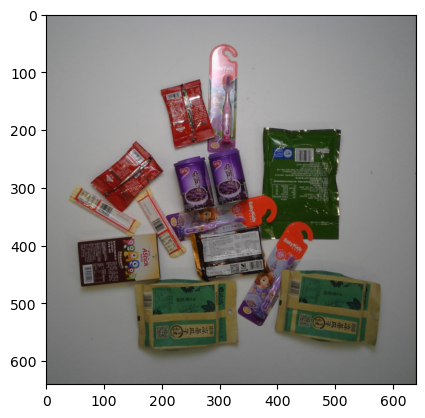

In [33]:
import matplotlib.pyplot as plt

def display_image(axis, image_tensor):
    """Display a tensor as an image

    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """

    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError(
            "The `display_image` function expects a `torch.Tensor` "
            + "use the `ToTensor` transformation to convert the images to tensors."
        )

    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)


# Example usage
_, axis = plt.subplots()
some_random_index = 60000
# Here we use the __getitem__ method as a "magic" method.
# Implementing it for a class, enables square bracket '[]' indexing
image_tensor, _, label, _ = multiobject_train_dataset[some_random_index]
display_image(axis, image_tensor)